http://localhost:8080/notebooks/git/shopee-product-matching/working/dev0014--threshold--3feats.ipynb

# setup

In [9]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

HOME = '/data/git/shopee-product-matching'
pdata = f'{HOME}/input/shopee-product-matching'

# metric

In [2]:
# def getMetric(col):
#     def f1score(row):
#         n = len( np.intersect1d(row.target,row[col]) )
#         return 2*n / (len(row.target)+len(row[col]))
#     return f1score

def getf1(x,y):
    n = len(np.intersect1d(x,y))
    return 2*n / (len(x)+len(y))

def getf1s(xs,ys):
    return (getf1(x,y) for x,y in zip(xs,ys))

def meanf1(xs,ys):
    return np.mean(list(getf1s(xs, ys)))

# data and target

In [3]:
df = pd.read_csv(f'{pdata}/train.csv')

pids = df.posting_id.values

display(df.head(2))

grp2ids = df.groupby('label_group').posting_id.agg('unique').to_dict()
targets = df.label_group.map(grp2ids)

targets[:2]

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045


0     [train_129225211, train_2278313361]
1    [train_3386243561, train_3423213080]
Name: label_group, dtype: object

# baselines

## self baseline

In [4]:
preds = df.posting_id.apply(lambda x: [x])
print(preds[0], targets[0])

meanf1(preds,targets)

['train_129225211'] ['train_129225211' 'train_2278313361']


0.4608481791365001

## same hash baseline

In [5]:
hsh2ids = df.groupby('image_phash').posting_id.agg('unique').to_dict()
preds = df.image_phash.map(hsh2ids)
print(preds[0], targets[0])

meanf1(preds,targets)

['train_129225211'] ['train_129225211' 'train_2278313361']


0.5530933399168149

## image sims

In [6]:
feats = np.load(f"{HOME}/output/dev0005/vfeats.npy")
feats.shape, feats.min(), feats.max()

((34250, 1280), -0.26786401867866516, 6.02245569229126)

In [7]:
feats[:3,:10]

array([[-0.15162036, -0.20200732, -0.07988038, -0.01763012, -0.03462825,
         0.08004601,  0.22869602, -0.11427961,  0.00247513, -0.10201114],
       [ 0.08407991, -0.1057606 , -0.10895672,  0.28222248, -0.1978499 ,
        -0.0591195 , -0.14243783, -0.08416796,  0.04849764, -0.22471595],
       [-0.10569465, -0.15444288,  0.21543284,  0.08538498,  0.25567672,
        -0.12253671,  1.20475686, -0.01302597, -0.04933466,  0.46700051]])

In [ ]:
nbrs = NearestNeighbors(n_neighbors=10, algorithm='auto').fit(feats)
dists, idx = nbrs.kneighbors(feats)

In [69]:
dists.shape

(34250, 10)

In [54]:
idx

array([[    0,   686,  9813, ...,  7057, 27738, 14434],
       [    1,   469,   194, ..., 33333,  4713,  2140],
       [    2,  3446,  7973, ..., 23583, 33486,  3525],
       ...,
       [34247, 23056, 18379, ...,  1405,  4447,   179],
       [34248, 13887, 20813, ..., 19748, 18190, 16656],
       [34249, 33792, 18226, ..., 23010, 16278, 14847]])

In [28]:
dists.mean(), dists.max()

(8.296703878835759, 18.185865601726224)

In [38]:
preds_idx = [o[:2] for o in idx]
preds = [pids[o] for o in preds_idx]
meanf1(preds,targets)

0.5734897998861994

In [64]:
thrsh = 10
isclose = dists<=thrsh
preds_idx = (np.where(x)[0] for x in isclose)
preds = [pids[o] for o in preds_idx]
meanf1(preds,targets)

0.00010063042248529582

In [66]:
def get_preds_by_thrsh(dists, thrsh):
    isclose = dists<=thrsh
    preds_idx = (np.where(x)[0] for x in isclose)
    return [pids[o] for o in preds_idx]

preds = get_preds_by_thrsh(dists, thrsh=10)
meanf1(preds,targets)

0.00010063042248529582

In [67]:
thrshes = np.linspace(0,20,num=21)
thrshes

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20.])

In [68]:
f1_lst = []
for thrsh in tqdm(thrshes):
    preds = get_preds_by_thrsh(dists, thrsh)
    f1_lst.append(meanf1(preds,targets))
    

100%|██████████| 21/21 [00:21<00:00,  1.01s/it]


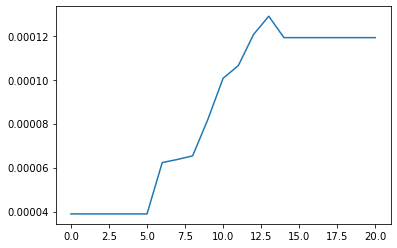

In [70]:
plt.plot(thrshes, f1_lst)

In [71]:
f1_best, thrsh_best = sorted(zip(f1_lst, thrshes), reverse=True)[0]
f1_best, thrsh_best

(0.00012885468617542466, 13.0)

In [72]:
def find_best(sims, thrshes = np.linspace(0.7,1.,num=31)):
    f1_lst = []
    preds_lst = []
    for thrsh in tqdm(thrshes):
        preds = get_preds_by_thrsh(sims, thrsh)
        preds_lst.append(preds)
        f1 = meanf1(preds,targets)
        f1_lst.append(f1)
    f1_best, thrsh_best, preds_best = sorted(zip(f1_lst, thrshes, preds_lst), reverse=True)[0]
    return f1_best, thrsh_best, preds_best

In [20]:
f1_best, thrsh_best, preds_best = find_best(sims)

100%|██████████| 31/31 [01:33<00:00,  3.01s/it]


In [21]:
f1_best, thrsh_best

(0.6661021248340279, 0.8099999999999999)

## text sims

In [22]:
sims = np.load(f"{HOME}/data/dev0005/tsims.npy")

In [23]:
sims.shape, sims.min(), sims.max()

((34250, 34250), 0.47264884998705725, 1.0000000000000022)

In [24]:
sims[:3,:10]

array([[1.        , 0.76773516, 0.78224733, 0.79733796, 0.75798257,
        0.78678093, 0.72650628, 0.79633748, 0.77628437, 0.84752702],
       [0.76773516, 1.        , 0.81569494, 0.7719416 , 0.77873317,
        0.77790889, 0.77254736, 0.79631262, 0.7891979 , 0.81986963],
       [0.78224733, 0.81569494, 1.        , 0.75700884, 0.79716831,
        0.80797851, 0.75229726, 0.78278977, 0.80849455, 0.85705353]])

In [27]:
thrsh = 0.9
isclose = sims>=thrsh
preds_idx = (np.where(x)[0] for x in isclose)
preds = [pids[o] for o in preds_idx]
meanf1(preds,targets)

0.25259499964312493

In [29]:
preds = get_preds_by_thrsh(sims, thrsh=0.9)
meanf1(preds,targets)

0.25259499964312493

In [35]:
thrshes = np.linspace(0.9,1.,num=11)
thrshes

array([0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  ])

In [38]:
f1_lst = []
for thrsh in tqdm(thrshes):
    preds = get_preds_by_thrsh(sims, thrsh)
    f1_lst.append(meanf1(preds,targets))

100%|██████████| 11/11 [00:33<00:00,  3.03s/it]


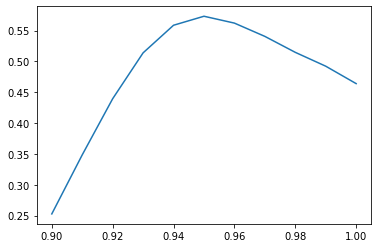

In [39]:
plt.plot(thrshes, f1_lst)

In [40]:
f1_best, thrsh_best = sorted(zip(f1_lst, thrshes), reverse=True)[0]
f1_best, thrsh_best

(0.5732622373044297, 0.95)

In [41]:
f1_best, thrsh_best, preds_best = find_best(sims, np.linspace(0.9,1.,num=11))

100%|██████████| 11/11 [00:33<00:00,  3.05s/it]


In [42]:
f1_best, thrsh_best

(0.5732622373044297, 0.95)

## hash sims

In [43]:
sims = np.load(f"{HOME}/data/dev0011/hsims.npy")

In [52]:
sims.shape, sims.min(), sims.max()

((34250, 34250), 0.01694915254237288, 1.0)

In [53]:
sims[:3,:10]

array([[1.        , 0.02325581, 0.02439024, 0.03225806, 0.03030303,
        0.02857143, 0.03030303, 0.03225806, 0.02564103, 0.02702703],
       [0.02325581, 1.        , 0.03448276, 0.03448276, 0.02857143,
        0.03030303, 0.02702703, 0.04      , 0.03448276, 0.03030303],
       [0.02439024, 0.03448276, 1.        , 0.02857143, 0.02222222,
        0.03703704, 0.02857143, 0.03030303, 0.03448276, 0.03030303]])

In [54]:
thrsh = 0.9
isclose = sims>=thrsh
preds_idx = (np.where(x)[0] for x in isclose)
preds = [pids[o] for o in preds_idx]
meanf1(preds,targets)

0.5530933399168149

In [86]:
preds = get_preds_by_thrsh(sims, thrsh=0.05)
meanf1(preds,targets)

0.06096319561101737

In [89]:
preds = get_preds_by_thrsh(sims, thrsh=0.08)
meanf1(preds,targets)

0.5846935996965729

In [85]:
preds = get_preds_by_thrsh(sims, thrsh=0.1)
meanf1(preds,targets)

0.5956242937941346

In [90]:
preds = get_preds_by_thrsh(sims, thrsh=0.15)
meanf1(preds,targets)

0.5865515822087048

In [91]:
preds = get_preds_by_thrsh(sims, thrsh=0.25)
meanf1(preds,targets)

0.575980978490745

In [92]:
preds = get_preds_by_thrsh(sims, thrsh=0.9)
meanf1(preds,targets)

0.5530933399168149

In [110]:
thrshes = np.linspace(0.07, 0.15,num=21)
thrshes

array([0.07 , 0.074, 0.078, 0.082, 0.086, 0.09 , 0.094, 0.098, 0.102,
       0.106, 0.11 , 0.114, 0.118, 0.122, 0.126, 0.13 , 0.134, 0.138,
       0.142, 0.146, 0.15 ])

In [111]:
f1_lst = []
for thrsh in tqdm(thrshes):
    preds = get_preds_by_thrsh(sims, thrsh)
    f1_lst.append(meanf1(preds,targets))

100%|██████████| 21/21 [01:03<00:00,  3.02s/it]


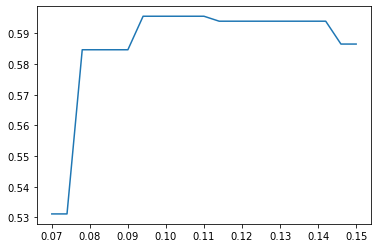

In [112]:
plt.plot(thrshes, f1_lst)

In [113]:
f1_best, thrsh_best = sorted(zip(f1_lst, thrshes), reverse=True)[0]
f1_best, thrsh_best

(0.5956242937941346, 0.11)

In [114]:
f1_best, thrsh_best, preds_best = find_best(sims, np.linspace(0.9,1.,num=11))

100%|██████████| 11/11 [00:32<00:00,  2.98s/it]


In [115]:
f1_best, thrsh_best

(0.5530933399168149, 1.0)

# combine - todo

In [1]:
!nvidia-smi

Mon Mar 22 01:02:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   36C    P0    38W / 300W |  14344MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# setup

In [2]:
%load_ext autoreload
%autoreload 2
%aimport

HOME = '/data/git/shopee-product-matching'
import sys
sys.path.append(f"{HOME}/src")

p_in = f'{HOME}/input'
p_comp = f'{p_in}/shopee-product-matching'
p_out = f'{HOME}/output/dev0017'

!mkdir -p {p_out}
from utils import *
import tmdl
import vmdl
from vmdl import VDataset, tfms



Modules to reload:
all-except-skipped

Modules to skip:



In [3]:
p_imgs = f"{p_comp}/test_images"
df = pd.read_csv(f'{p_comp}/test.csv')
df.shape

(3, 4)

In [4]:
p_imgs = f"{p_comp}/train_images"
df = pd.read_csv(f'{p_comp}/train.csv', nrows=10000)
df.shape

(10000, 5)

In [5]:
pids = df.posting_id.values

In [6]:
from efficientnet_pytorch import EfficientNet
mdl = EfficientNet.from_pretrained("efficientnet-b0")

feats_v = vmdl.mk_sims(df, p_imgs, mdl)

Loaded pretrained weights for efficientnet-b0


In [7]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
%%time
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(feats_v)
distances, indices = nbrs.kneighbors(feats_v)

In [27]:
distances

array([[0.        , 1.78029711, 1.93365504, ..., 2.5532459 , 2.5532459 ,
        2.55396792],
       [0.        , 0.68735381, 0.72377956, ..., 3.05808825, 3.07147124,
        3.07170258],
       [0.        , 2.21592239, 2.21760624, ..., 3.07715974, 3.07743135,
        3.07824538],
       ...,
       [0.        , 0.17569725, 1.95321067, ..., 2.70514978, 2.70607868,
        2.71133189],
       [0.        , 2.08091198, 2.1150323 , ..., 2.59611665, 2.61358401,
        2.6157734 ],
       [0.        , 1.7884243 , 1.87985213, ..., 2.85938582, 2.86022185,
        2.86027602]])

In [28]:
indices

array([[  0, 587, 246, ..., 405, 404, 892],
       [  1, 194, 469, ..., 826, 370, 191],
       [  2, 662, 735, ..., 625, 388, 387],
       ...,
       [997, 520, 185, ..., 167,   7, 245],
       [998, 309, 838, ...,  32, 629, 178],
       [999, 642, 288, ..., 225, 275, 791]])

In [7]:
sims_v = vmdl.mk_sims(df, p_imgs)

Loaded pretrained weights for efficientnet-b0


In [8]:
sims_t = tmdl.mk_sims(df)

In [9]:
sims_h = mk_hsims(df)

In [16]:
??tmdl.mk_sims

In [17]:
type(sims_t)

numpy.ndarray

In [ ]:
preds_v = get_preds_by_thrsh(sims_v, thrsh_v)
preds_t = get_preds_by_thrsh(sims_t, thrsh_t)
preds_h = get_preds_by_thrsh(sims_h, thrsh_h)

preds_comb = (np.unique(np.concatenate(o)) for o in zip(preds_v,preds_t,preds_h))

In [ ]:
preds_pids = preds2pids(preds_comb, pids)

In [ ]:
sub = df[['posting_id']].copy()

In [ ]:
sub['matches'] = np.array([" ".join(o) for o in preds_pids])

In [17]:
sub.head()

,posting_id,matches
0,train_129225211,train_129225211
1,train_3386243561,train_3386243561
2,train_2288590299,train_2288590299
3,train_2406599165,train_2406599165
4,train_3369186413,train_3369186413


In [18]:
sub.to_csv(f'{p_out}/submission.csv',index=False)

In [19]:
!nvidia-smi

Sun Mar 21 18:34:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   40C    P0    40W / 300W |   6443MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  